In [1]:
import torch
import math
from nnsight import CONFIG
from nnsight import LanguageModel
import nnsight
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import random
from collections import defaultdict
import yaml 

load_dotenv()

c:\Users\durrc\OneDrive\Desktop\mech_interp_work\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import pickle

# Save object to a file
def save_pickle(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

# Load object from a file
def load_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
    

import hashlib

def hash_string(input_string, algorithm='sha256'):
    """
    Hashes a string using the specified algorithm.

    Args:
        input_string: The string to be hashed.
        algorithm: The hashing algorithm to use (e.g., 'sha256', 'md5', 'sha1').
                   Defaults to 'sha256'.

    Returns:
        The hexadecimal representation of the hashed string.
    """

    try:
        # Encode the string to bytes
        encoded_string = input_string.encode('utf-8')

        # Create a hash object using the specified algorithm
        hash_object = hashlib.new(algorithm)

        # Update the hash object with the encoded string
        hash_object.update(encoded_string)

        # Return the hexadecimal representation of the hash
        return hash_object.hexdigest()

    except ValueError:
        return f"Invalid hashing algorithm: {algorithm}"

In [3]:
# importing from my own code 
from activation_transplanting import *
from analysis_tools import *

In [4]:
# read the api_key
CONFIG.set_default_api_key(os.environ.get('NDIF_KEY'))

# read the hf token
os.environ['HF_TOKEN'] = os.environ.get('HF_TOKEN')

In [5]:
NDIF_models = [
    "meta-llama/Meta-Llama-3.1-405B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B",
    "meta-llama/Meta-Llama-3.1-70B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
] 

# inexaustive list
non_NDIF_models = [
    "meta-llama/Meta-Llama-3.1-8B",
]

In [6]:
# choose a model 
llama_model_string = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# remote = use NDIF
remote = True 

if remote and (llama_model_string not in NDIF_models):
    remote = False 
    print("Model not available on NDIF")

# load a model
llama = LanguageModel(llama_model_string)

# commented out for now
tk = LLamaExamineToolkit(
    llama_model=llama, 
    remote=True, 
)

Let's try to generate short-ish prompts which requires a few steps of reasoning. 

In [7]:
def map_prompt_to_file_string(string):
    assert "<｜User｜>" in string
    simplified_string = string.replace("<｜User｜>", "").replace("<｜Assistant｜>", "").replace("\\", "").lower()
    
    def is_allowed(char):
        return (ord('a')<=ord(char)<=ord('z')) or (ord('0')<=ord(char)<=ord('9'))
    
    hashed = hash_string(string)

    return ''.join([c if is_allowed(c) else '_' for c in simplified_string]).replace("__", "")+str(hashed)

In [8]:
# mostly for debugging

USE_CACHE = True

In [9]:
if USE_CACHE:
    with open('prompt_activity_cache.yaml', 'r') as file:
        prompt_cache = yaml.safe_load(file)
    
    loaded_cache = {}
    if prompt_cache is not None:
        for prompt in prompt_cache:
            loaded_cache[prompt] = load_pickle(prompt_cache[prompt])
    else:
        prompt_cache = {}

In [10]:
def generate_and_return_activity(
    llama,
    source_string: str,
    num_new_tokens: int,
    remote=True,
):
    """
    given a source string, generate at most num_new_tokens
    and return their activation_containers

    Returns:
        The activation container containing the target activations 
    """

    if USE_CACHE and map_prompt_to_file_string(source_string) in loaded_cache:
        ac = loaded_cache[map_prompt_to_file_string(source_string)]
        print(ac.token_idx_to_value_dict)
        return ac


    print(source_string)
    layers = llama.model.layers
    activation_container = ActivationContainer()

    with llama.generate(
        source_string,
        max_new_tokens=num_new_tokens,
        remote=remote,
    ) as tracer:
        # Intervene on the first generation step only
        for idx in range(num_new_tokens):
            for layer_idx, layer in enumerate(layers):
                activation_container.set_activation(
                    token_index=idx,
                    layer_index=layer_idx,
                    tensor=layer.input[:, -1, :].save(),
                    label="residual_input",
                )
                if layer_idx == llama.config.num_hidden_layers - 1:
                    activation_container.set_activation(
                        token_index=idx,
                        layer_index=layer_idx,
                        tensor=llama.model.norm.output[
                            :, -1, :
                        ].save(),
                        label="final_residual_output",
                    )
            # Proceed to the next token generation step
            layers.next()

        # Save and retrieve the generator output tokens
        out = llama.generator.output.save()
    
    # deal with the first token
    first_token_int = llama.tokenizer.encode(source_string)[-1]
    activation_container.set_tokens(
        token_index=0,
        token_int=first_token_int,
        token_string=llama.tokenizer.decode(first_token_int),
    )

    # now deal with the remaining token ints
    for token_idx, token_int in enumerate(out[0][:-1], start=1):
        activation_container.set_tokens(
            token_index=token_idx,
            token_int=token_int,
            token_string=llama.tokenizer.decode(token_int),
        )
    
    if USE_CACHE:
        # save the activity_cash under a special string name 
        cache_key = map_prompt_to_file_string(source_string)
        pickle_file = os.path.join("activity_container_pickles", cache_key+str(np.random.randint(1000000))+".pkl")
        save_pickle(pickle_file, pickle_file)
        #save_pickle(activation_container, pickle_file)
        prompt_cache[cache_key] = pickle_file
        with open('prompt_activity_cache.yaml', 'w') as file:
            yaml.safe_dump(prompt_cache, file)
        
        loaded_cache[cache_key] = activation_container
    
    #activation_container.set_values()
    return activation_container

In [11]:
llama.tokenizer.encode("<｜User｜>What are you?<｜Assistant｜><think>\n")

[128000, 128011, 3923, 527, 499, 30, 128012, 128013, 198]

In [12]:
ac = generate_and_return_activity(
    llama,
    source_string="<｜User｜>What are you?<｜Assistant｜><think>\n",
    num_new_tokens=100,
    remote=True,
)

AttributeError: 'str' object has no attribute 'token_idx_to_value_dict'

In [ ]:
ac.set_values()

ValueError: Accessing value before it's been set.

In [ ]:
ac.set_values()

In [ ]:
type(ac.get_activation(token_index=0, layer_index=0, label='residual_input'))

nnsight.intervention.graph.proxy.InterventionProxy

In [ ]:
with nnsight.local():
    v=ac.get_activation(token_index=0, layer_index=0, label='residual_input')

In [ ]:
type(ac.get_activation(token_index=0, layer_index=0, label='residual_input'))

nnsight.intervention.graph.proxy.InterventionProxy

In [ ]:
type(v)

torch.Tensor

In [ ]:
v

tensor([[-0.0014,  0.0012,  0.0009,  ..., -0.0043,  0.0015,  0.0015]],
       dtype=torch.bfloat16)

In [ ]:
kjh

NameError: name 'kjh' is not defined

Test this out

Now let's try to construct a dataset of computations, or things requiring some thoughts 



In [ ]:
def collect_region_data(regions_list, ac) -> dict[tuple[str, int], list[torch.Tensor]]:
    """ 
    create a dictionary mapping each (str, int) tuple to 
    a corresponding list of tensors
    each of shape (n, d)

    (each element in the list is its own layer's residuals)
    """
    region_dict = dict()
    for region_list in regions_list:
        for el in region_list:
            if el not in region_dict:
                region_dict[el] = [[r]
                    for r in ac.get_activations_at_token_idx(0, "residual_input")
                ]
            else:
                for i, r in enumerate(ac.get_activations_at_token_idx(0, "residual_input")):
                    region_dict[el][i].append(r)
    
    # now combine
    return {
        key: [torch.cat(tensor_list, dim=0) for tensor_list in list_of_tensor_list]
        for key, list_of_tensor_list in region_dict.items()
    }



In [ ]:
def extract_reasoning_data(llama, string, think_pad=0, num_tokens=300):
    """ 
    given a string, format it, and generate output tokens 
    corresponding to the resulting reasoning 

    We'll split this into two sets of data:
        1) data corresponding to reasoning sections 
        text within <think>\n\n<\think> 
        for example:
            <think>\nExample thinking region\n<\think>

            the extracted token activation containers here
            would correspond to 
            "Example thinking region"
        
        2) data corresponding to text outside of reasoning sections

    think_pad: default = 0
        By default this is zero. This optionally allows us to pad the regions we extract
        Both inside and outside of thinking regions, we will skip think_pad tokens 

        this is to avoid the possibility of simply detecting the vectors corresponding 
        directly to the tokens <think>, \n, and <\think>
    
    return two dictionaries
    """
    ac = generate_and_return_activity(
        llama,
        source_string=f"<｜User｜>{string}<｜Assistant｜><think>\n",
        num_new_tokens=num_tokens,
        remote=True,
    )
    
    # Identify the first <think> token
    start_index = None
    for i in range(len(ac.token_idx_to_value_dict)):
        if ac.token_idx_to_value_dict[i][-1] == 128013:
            start_index = i + 1
            break
    assert start_index is not None, "No <think> token found in the input."+f"<｜User｜>{string}<｜Assistant｜><think>\n"
    
    # Collect tokens into regions based on whether we're "thinking" or not.
    think_regions = []
    other_regions = []
    thinking = True
    cur_region = []
    for idx in range(start_index, len(ac.token_idx_to_value_dict)):
        token = ac.get_token_by_index(idx)
        
        if thinking and token[0] == '</think>':
            think_regions.append(cur_region)
            thinking = False 
            cur_region = []
        elif not thinking and token[0] == '<think>':
            other_regions.append(cur_region)
            thinking = True
            cur_region = []
        else:
            cur_region.append(token)
    
    # Append any remaining tokens after loop ends.
    if cur_region:
        if thinking:
            think_regions.append(cur_region)
        else:
            other_regions.append(cur_region)
    
    #print(think_regions)
    #print("-----------")
    #print(other_regions)
    
    # Adjust newline tokens within each region (modify the region list directly)
    for region in think_regions:
        if region and region[0][-1] == 198:
            region.pop(0)
        if region and region[-1][-1] == 198:
            region.pop()
    for region in other_regions:
        if region and region[0][-1] == 271:
            region.pop(0)
    
    # Apply padding only if think_pad is nonzero.
    def apply_padding(regions, pad):
        if pad == 0:
            return regions
        # Only include regions that are long enough after padding.
        return [r[pad: -pad] for r in regions if len(r) > (1 + 2 * pad)]
    
    think_regions = apply_padding(think_regions, think_pad)
    other_regions = apply_padding(other_regions, think_pad)
    
    # Collect and return region data.
    think_dict = collect_region_data(think_regions, ac)
    other_dict = collect_region_data(other_regions, ac)

    return think_dict, other_dict


In [ ]:
def combine_reasoning_data(dict_1, dict_2):
    """ 
    combine reasoning data dicts
    """
    all_keys = list(set(dict_1.keys()).union(dict_2.keys()))

    combined_dict = {}
    for k in all_keys:
        if k in dict_1 and k in dict_2:
            if len(dict_1[k]) != len(dict_2[k]):
                raise ValueError(f"Mismatch in list lengths for key {k}")
            combined_dict[k] = [torch.cat([t1, t2], dim=0) for t1, t2 in zip(dict_1[k], dict_2[k])]
        elif k in dict_1:
            combined_dict[k] = dict_1[k]
        else:
            combined_dict[k] = dict_2[k]
    
    return combined_dict


In [ ]:
def read_prompts(file_path="reasoning-prompts.md"):
    """
    Read prompts from a text file and return them as a list of strings.
    
    Args:
        file_path (str): Path to the file containing reasoning prompts
        
    Returns:
        list: A list of strings, each containing a reasoning prompt
    """
    prompts = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Skip empty lines, headers, and category labels
                line = line.strip()
                if (line and 
                    not line.startswith('#') and 
                    not line.startswith('##') and
                    not line == ""):
                    
                    # Extract the prompt text by removing the number and period
                    parts = line.split('. ', 1)
                    if len(parts) > 1 and parts[0].isdigit():
                        prompt = parts[1]
                    else:
                        prompt = line
                        
                    prompts.append(prompt)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"Error reading prompts: {e}")
    
    return prompts

# now let's collect reasoning data

In [ ]:
def collect_reasoning_dataset(string_list: list[str]):
    output_think_dict = {}
    output_other_dict = {}

    for string in string_list:
        think_dict, other_dict = extract_reasoning_data(llama, string, think_pad=0, num_tokens=300)

        output_think_dict = combine_reasoning_data(output_think_dict, think_dict)
        output_other_dict = combine_reasoning_data(output_other_dict, other_dict)

    return output_think_dict, output_other_dict

In [ ]:
reasoning_string_list = read_prompts()

In [ ]:
output_think_dict, output_other_dict = collect_reasoning_dataset(reasoning_string_list)

<｜User｜>What is the square root of 144?<｜Assistant｜><think>



2025-03-31 23:38:02,077 ad99d34a-89c4-4dfe-9619-ae3abcaea3cb - RECEIVED: Your job has been received and is waiting approval.
2025-03-31 23:38:02,862 ad99d34a-89c4-4dfe-9619-ae3abcaea3cb - APPROVED: Your job was approved and is waiting to be run.
2025-03-31 23:38:07,900 ad99d34a-89c4-4dfe-9619-ae3abcaea3cb - RUNNING: Your job has started running.
2025-03-31 23:38:37,152 ad99d34a-89c4-4dfe-9619-ae3abcaea3cb - COMPLETED: Your job has been completed.


In [ ]:
hgf

In [ ]:
output_think_dict

{(' need',
  1205): [tensor([[-0.0014,  0.0012,  0.0009,  ..., -0.0043,  0.0015,  0.0015]],
         dtype=torch.bfloat16), tensor([[ 0.0047, -0.0140,  0.0015,  ..., -0.0311,  0.0042,  0.0065]],
         dtype=torch.bfloat16), tensor([[ 0.0112, -0.0096, -0.0128,  ..., -0.0415,  0.0057,  0.0059]],
         dtype=torch.bfloat16), tensor([[ 0.0056,  0.0066, -0.0020,  ..., -0.0532,  0.0106,  0.0022]],
         dtype=torch.bfloat16), tensor([[-0.0013, -0.0571,  0.0028,  ..., -0.0479,  0.0260, -0.0255]],
         dtype=torch.bfloat16), tensor([[-0.1016, -0.0225,  0.0898,  ...,  0.0189, -0.0264, -0.0007]],
         dtype=torch.bfloat16), tensor([[-0.1348, -0.0947,  0.0767,  ...,  0.0620, -0.0291,  0.0615]],
         dtype=torch.bfloat16), tensor([[-0.1377, -0.0972,  0.1504,  ...,  0.0378, -0.0366,  0.0967]],
         dtype=torch.bfloat16), tensor([[-0.0569, -0.1108,  0.0376,  ...,  0.0559,  0.0762,  0.0967]],
         dtype=torch.bfloat16), tensor([[-0.0251, -0.1826,  0.0120,  ...,  0.1777,  

# Now analyze reasoning data

let's perform LDA for each layer

In [ ]:
output_think_dict

{(' need',
  1205): [tensor([[-0.0014,  0.0012,  0.0009,  ..., -0.0043,  0.0015,  0.0015]],
         dtype=torch.bfloat16), tensor([[ 0.0047, -0.0140,  0.0015,  ..., -0.0311,  0.0042,  0.0065]],
         dtype=torch.bfloat16), tensor([[ 0.0112, -0.0096, -0.0128,  ..., -0.0415,  0.0057,  0.0059]],
         dtype=torch.bfloat16), tensor([[ 0.0056,  0.0066, -0.0020,  ..., -0.0532,  0.0106,  0.0022]],
         dtype=torch.bfloat16), tensor([[-0.0013, -0.0571,  0.0028,  ..., -0.0479,  0.0260, -0.0255]],
         dtype=torch.bfloat16), tensor([[-0.1016, -0.0225,  0.0898,  ...,  0.0189, -0.0264, -0.0007]],
         dtype=torch.bfloat16), tensor([[-0.1348, -0.0947,  0.0767,  ...,  0.0620, -0.0291,  0.0615]],
         dtype=torch.bfloat16), tensor([[-0.1377, -0.0972,  0.1504,  ...,  0.0378, -0.0366,  0.0967]],
         dtype=torch.bfloat16), tensor([[-0.0569, -0.1108,  0.0376,  ...,  0.0559,  0.0762,  0.0967]],
         dtype=torch.bfloat16), tensor([[-0.0251, -0.1826,  0.0120,  ...,  0.1777,  

In [ ]:
layerwise_LDA_results = [
    perform_token_normalized_lda(
        data_0 = {k:v[i] for k, v in output_think_dict.items()},
        data_1 = {k:v[i] for k, v in output_other_dict.items()},
        visualize=False
    )
    for i in range(1, 32)
]

KeyboardInterrupt: 

In [ ]:
# in common? 

words = [] 

for k in output_think_dict:
    if k in output_other_dict:
        words.append((k, min(output_think_dict[k][0].shape[0], output_other_dict[k][0].shape[0])))

In [ ]:
words.sort(key = lambda x: -x[-1])

for w in words:
    print(w)

((' ', 220), 227)
((' the', 279), 176)
(('.', 13), 117)
(('{', 90), 94)
((' of', 315), 83)
(('2', 17), 73)
(('3', 18), 71)
((',', 11), 61)
((' =', 284), 54)
((':', 25), 51)
((' is', 374), 42)
(('frac', 38118), 41)
((' \\', 1144), 41)
(('1', 16), 39)
(('}{', 15523), 38)
((' to', 311), 37)
((' \\(', 18240), 36)
(('8', 23), 32)
((' by', 555), 29)
(('6', 21), 29)
((' for', 369), 27)
((' total', 2860), 26)
((' a', 264), 25)
(('.\n\n', 382), 25)
(('4', 19), 25)
(('5', 20), 22)
((')', 8), 19)
((' find', 1505), 19)
((' these', 1521), 18)
((' number', 1396), 17)
((' and', 323), 17)
(('12', 717), 16)
(('7', 22), 16)
(('To', 1271), 15)
((' days', 2919), 14)
(('{\\', 36802), 14)
((' (', 320), 14)
((' +', 489), 13)
((' The', 578), 13)
((' y', 379), 13)
(('-', 12), 13)
((':\n\n', 1473), 13)
((' length', 3160), 13)
((' determine', 8417), 13)
((':\n', 512), 13)
(('boxed', 80175), 12)
((' sides', 11314), 12)
(('0', 15), 12)
(('\\', 59), 12)
((' in', 304), 12)
((' x', 865), 12)
((' when', 994), 11)
((' 

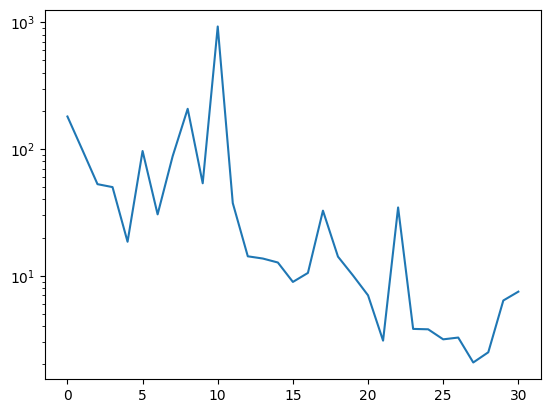

In [ ]:
plt.plot([v[-1] for v in layerwise_LDA_results])
plt.yscale("log")

In [ ]:
layerwise_LDA_results[0]

(array([ 0.00311734, -0.01863096,  0.0118199 , ..., -0.00867009,
        -0.02950646, -0.01085656], shape=(4096,), dtype=float32),
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         9.5693395e-06, -2.0946609e-05, -2.6840600e-05],
       shape=(21111,), dtype=float32),
 array([0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 9.569339e-06,
        9.569339e-06, 9.569339e-06], shape=(4327,), dtype=float32),
 np.float32(64.005775),
 np.float32(180.44247))

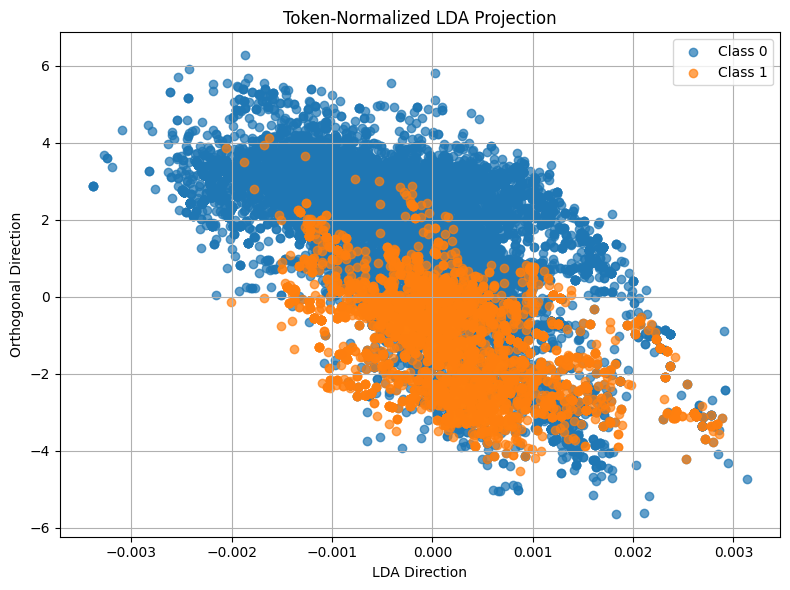

(array([ 0.0016406 , -0.01322602,  0.01165712, ...,  0.01126911,
         0.00273293, -0.00786139], shape=(4096,), dtype=float32),
 array([ 0.        ,  0.        ,  0.        , ...,  0.00025216,
        -0.00086708, -0.00173929], shape=(21111,), dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.00025216, 0.00025216,
        0.00025216], shape=(4327,), dtype=float32),
 np.float32(64.013664),
 np.float32(926.2042))

In [ ]:
perform_token_normalized_lda(
        data_0 = {k:v[11] for k, v in output_think_dict.items()},
        data_1 = {k:v[11] for k, v in output_other_dict.items()},
        visualize=True
    )

In [ ]:
jhgjhg

NameError: name 'jhgjhg' is not defined

In [ ]:
think_dict, other_dict = extract_reasoning_data(llama, "briefly, what is the square root of 9", think_pad=0)

2025-03-27 07:21:55,345 0b570dc8-f3e8-43c8-bbaf-e91a2505bd98 - RECEIVED: Your job has been received and is waiting approval.
2025-03-27 07:21:57,413 0b570dc8-f3e8-43c8-bbaf-e91a2505bd98 - APPROVED: Your job was approved and is waiting to be run.
2025-03-27 07:22:02,914 0b570dc8-f3e8-43c8-bbaf-e91a2505bd98 - RUNNING: Your job has started running.
2025-03-27 07:22:41,343 0b570dc8-f3e8-43c8-bbaf-e91a2505bd98 - COMPLETED: Your job has been completed.


[[('\n', 198), ('To', 1271), (' determine', 8417), (' the', 279), (' square', 9518), (' root', 3789), (' of', 315), (' ', 220), ('9', 24), (',', 11), (' I', 358), (' first', 1176), (' recall', 19635), (' that', 430), (' a', 264), (' square', 9518), (' root', 3789), (' of', 315), (' a', 264), (' number', 1396), (' finds', 14035), (' a', 264), (' value', 907), (' that', 430), (',', 11), (' when', 994), (' multiplied', 56016), (' by', 555), (' itself', 5196), (',', 11), (' gives', 6835), (' the', 279), (' original', 4113), (' number', 1396), ('.', 13), (' For', 1789), (' ', 220), ('9', 24), (',', 11), (' this', 420), (' means', 3445), (' finding', 9455), (' a', 264), (' number', 1396), (' that', 430), (',', 11), (' when', 994), (' squared', 53363), (',', 11), (' equals', 17239), (' ', 220), ('9', 24), ('.\n\n', 382), ('I', 40), (' start', 1212), (' by', 555), (' testing', 7649), (' the', 279), (' number', 1396), (' ', 220), ('3', 18), ('.', 13), (' Squ', 20685), ('aring', 3329), (' ', 220

In [ ]:
"""
Reasoning Prompts Reader

This script reads a list of reasoning prompts from a text file and creates a Python list.
The prompts are categorized into math, English, world history, and science questions.
"""

def read_prompts(file_path="reasoning_prompts.txt"):
    """
    Read prompts from a text file and return them as a list of strings.
    
    Args:
        file_path (str): Path to the file containing reasoning prompts
        
    Returns:
        list: A list of strings, each containing a reasoning prompt
    """
    prompts = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Skip empty lines, headers, and category labels
                line = line.strip()
                if (line and 
                    not line.startswith('#') and 
                    not line.startswith('##') and
                    not line == ""):
                    
                    # Extract the prompt text by removing the number and period
                    parts = line.split('. ', 1)
                    if len(parts) > 1 and parts[0].isdigit():
                        prompt = parts[1]
                    else:
                        prompt = line
                        
                    prompts.append(prompt)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"Error reading prompts: {e}")
    
    return prompts

def get_prompts_by_category():
    """
    Get prompts organized by category
    
    Returns:
        dict: A dictionary with categories as keys and lists of prompts as values
    """
    all_prompts = read_prompts()
    
    # Define the prompt ranges for each category based on the numbering in the file
    categories = {
        "math": all_prompts[0:62],
        "english": all_prompts[62:124],
        "world_history": all_prompts[124:186],
        "science": all_prompts[186:250]
    }
    
    return categories

In [ ]:
think_dict

{('To',
  1271): [tensor([[-0.0014,  0.0012,  0.0009,  ..., -0.0043,  0.0015,  0.0015]],
         dtype=torch.bfloat16), tensor([[ 0.0020, -0.0159, -0.0067,  ..., -0.0184,  0.0002, -0.0004]],
         dtype=torch.bfloat16), tensor([[ 0.0048, -0.0114, -0.0161,  ..., -0.0223,  0.0028, -0.0054]],
         dtype=torch.bfloat16), tensor([[-0.0013, -0.0101,  0.0204,  ..., -0.0591,  0.0099, -0.0273]],
         dtype=torch.bfloat16), tensor([[ 0.0176, -0.0576,  0.0366,  ..., -0.0962,  0.0591, -0.0417]],
         dtype=torch.bfloat16), tensor([[-0.0664, -0.0723,  0.1016,  ..., -0.0222, -0.0435, -0.0327]],
         dtype=torch.bfloat16), tensor([[-0.0684, -0.1621,  0.0537,  ...,  0.0262, -0.0496,  0.0165]],
         dtype=torch.bfloat16), tensor([[-0.0557, -0.1475,  0.0869,  ...,  0.0096, -0.0172,  0.0908]],
         dtype=torch.bfloat16), tensor([[-0.0054, -0.1250,  0.0322,  ...,  0.0033,  0.0894,  0.0986]],
         dtype=torch.bfloat16), tensor([[-0.0132, -0.1787,  0.0023,  ...,  0.0928,  0.0

Now we'll combine many of these

In [ ]:
def 

In [ ]:
ac.get_token_by_index(0)

('<think>', 128013)

In [ ]:
len(ac.get_activations_at_token_idx(0, "residual_input"))

32

In [ ]:
ac.token_idx_to_value_dict

{0: ('<think>', 128013),
 1: ('<｜begin▁of▁sentence｜>', tensor(128000)),
 2: ('<｜User｜>', tensor(128011)),
 3: ('What', tensor(3923)),
 4: (' is', tensor(374)),
 5: (' the', tensor(279)),
 6: (' square', tensor(9518)),
 7: (' root', tensor(3789)),
 8: (' of', tensor(315)),
 9: (' ', tensor(220)),
 10: ('9', tensor(24)),
 11: ('?', tensor(30)),
 12: ('<｜Assistant｜>', tensor(128012)),
 13: ('<think>', tensor(128013)),
 14: ('\n', tensor(198)),
 15: ('To', tensor(1271)),
 16: (' find', tensor(1505)),
 17: (' the', tensor(279)),
 18: (' square', tensor(9518)),
 19: (' root', tensor(3789)),
 20: (' of', tensor(315)),
 21: (' ', tensor(220)),
 22: ('9', tensor(24)),
 23: (',', tensor(11)),
 24: (' I', tensor(358)),
 25: (' need', tensor(1205)),
 26: (' to', tensor(311)),
 27: (' determine', tensor(8417)),
 28: (' which', tensor(902)),
 29: (' number', tensor(1396)),
 30: (' multiplied', tensor(56016)),
 31: (' by', tensor(555)),
 32: (' itself', tensor(5196)),
 33: (' equals', tensor(17239)),

Obtain a 2d visualization of this 

In [ ]:
def extract_reasoning_data(string, format_string=True, think_pad=0):
    """ 
    given a string, format it, and generate output tokens 
    corresponding to the resulting reasoning 

    We'll split this into two sets of data:
        1) data corresponding to reasoning sections 
        text within <think>\n\n<\think> 
        for example:
            <think>\nExample thinking region\n<\think>

            the extracted token activation containers here
            would correspond to 
            "Example thinking region"
        
        2) data corresponding to text outside of reasoning sections

    think_pad: default = 0
        By default this is zero. This optionally allows us to pad the regions we extract
        Both inside and outside of thinking regions, we will skip think_pad tokens 

        this is to avoid the possibility of simply detecting the vectors corresponding 
        directly to the tokens <think>, \n, and <\think>
    """

In [ ]:
llama.lm_head(ac.get_activation(0, 31, 'final_residual_output'))

NNsightError: Cannot copy out of meta tensor; no data!

In [ ]:
vars(param)

{'path': '.lm_head',
 '_path': '.lm_head',
 '_module': Linear(in_features=4096, out_features=128256, bias=False),
 '_rename': None,
 '_iteration_stack': [0],
 '_fake_outputs': [],
 '_fake_inputs': [],
 '_output_stack': [None],
 '_input_stack': [None],
 '_tracer': <weakproxy at 0x0000021D80CA67A0 to NoneType at 0x00007FFF626CD250>,
 '_children': [],
 '_hook_handle': <torch.utils.hooks.RemovableHandle at 0x21d8362f890>}

In [ ]:
ac

ActivationContainer()

In [ ]:
llama.model

LlamaModel(
  (embed_tokens): Embedding(128256, 4096)
  (layers): ModuleList(
    (0-31): 32 x LlamaDecoderLayer(
      (self_attn): LlamaAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
      )
      (mlp): LlamaMLP(
        (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
    )
  )
  (norm): LlamaRMSNorm((4096,), eps=1e-05)
  (rotary_emb): LlamaRotaryEmbedding()
)

In [ ]:
jhg

In [ ]:
ac = generate_and_save_generated_activity(
    llama,
    source_string="<｜User｜><｜Assistant｜><think>\n",
    num_new_tokens=15,
    remote=True,
)

LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Llama-8B', vocab_size=128000, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	128000: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=T

In [ ]:
def find_chat_attributes(cls):
    """
    Searches the given class for attributes whose names contain
    either 'chat_template' or 'chat' (case-insensitive).

    Parameters:
        cls (type): The class to inspect.

    Returns:
        dict: A dictionary with attribute names as keys and their values.
    """
    search_terms = ['chat_template', 'chat']
    matching_attrs = {}

    # Iterate over all attributes in the class's directory.
    for attr_name in dir(cls):
        # Check if any search term appears in the attribute name.
        if any(term in attr_name.lower() for term in search_terms):
            try:
                matching_attrs[attr_name] = getattr(cls, attr_name)
            except AttributeError:
                # In case the attribute cannot be accessed.
                pass
    return matching_attrs

# Optionally, if you want to search not only the class itself but also its base classes:
def find_chat_attributes_recursive(cls):
    """
    Recursively searches the class and its base classes (MRO) for attributes
    whose names contain 'chat_template' or 'chat' (case-insensitive).

    Parameters:
        cls (type): The class to inspect.

    Returns:
        dict: A dictionary mapping class names to another dictionary of matching attributes.
    """
    search_terms = ['chat_template', 'chat']
    results = {}

    # Iterate over the class hierarchy.
    for base in cls.__mro__:
        base_matches = {}
        for attr_name in dir(base):
            if any(term in attr_name.lower() for term in search_terms):
                try:
                    base_matches[attr_name] = getattr(base, attr_name)
                except AttributeError:
                    pass
        results[base.__name__] = base_matches
    return results

# Example usage:
if __name__ == "__main__":
    # Define an example class with some chat-related attributes.
    class Example:
        chat_template = "Default Chat Template"
        chat_version = "1.0"
        not_related = "Nothing here"
    
    # Find matching attributes in the Example class.
    matches = find_chat_attributes(nnsight.modeling.language.LanguageModel)
    print("Direct matches:", matches)
    
    # Find matching attributes including from base classes (e.g., object).
    recursive_matches = find_chat_attributes_recursive(nnsight.modeling.language.LanguageModel)
    print("Recursive matches:", recursive_matches)


Direct matches: {}
Recursive matches: {'LanguageModel': {}, 'RemoteableMixin': {}, 'MetaMixin': {}, 'LoadableMixin': {}, 'NNsight': {}, 'object': {}}


In [ ]:
find_nested_chat_config(llama, max_depth=5, current_depth=0)

IndexError: pop from empty list

In [ ]:
type(llama)

nnsight.modeling.language.LanguageModel

In [ ]:
nnsight.modeling.language.LanguageModel

nnsight.modeling.language.LanguageModel